# Playing with embedding techniques and representations

### Author: Ridha Alkhabaz 
Here, we will look at data with known motifs and see if we could see some representations.


### Imports:

In [23]:
import copy
import os.path as osp
import time
import numpy as np
import pandas as pd 
import torch_geometric as pg
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
from sklearn.decomposition import PCA
from bhtsne import tsne
from tqdm import tqdm
from torch_geometric.datasets import Reddit, Twitch
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv

We will explore some of the datasets included in the snap data repository. 
First, we will see if there is a substructure without doing any embedding or reduction algorithms. 

In [2]:
dataset = Reddit('\tmp\reddit')
data = dataset[0]
subset_data_x = data.x[:2000]
subset_data_y = data.y[:2000]
x = np.array(subset_data_x, dtype=np.double)
y = np.array(subset_data_y)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

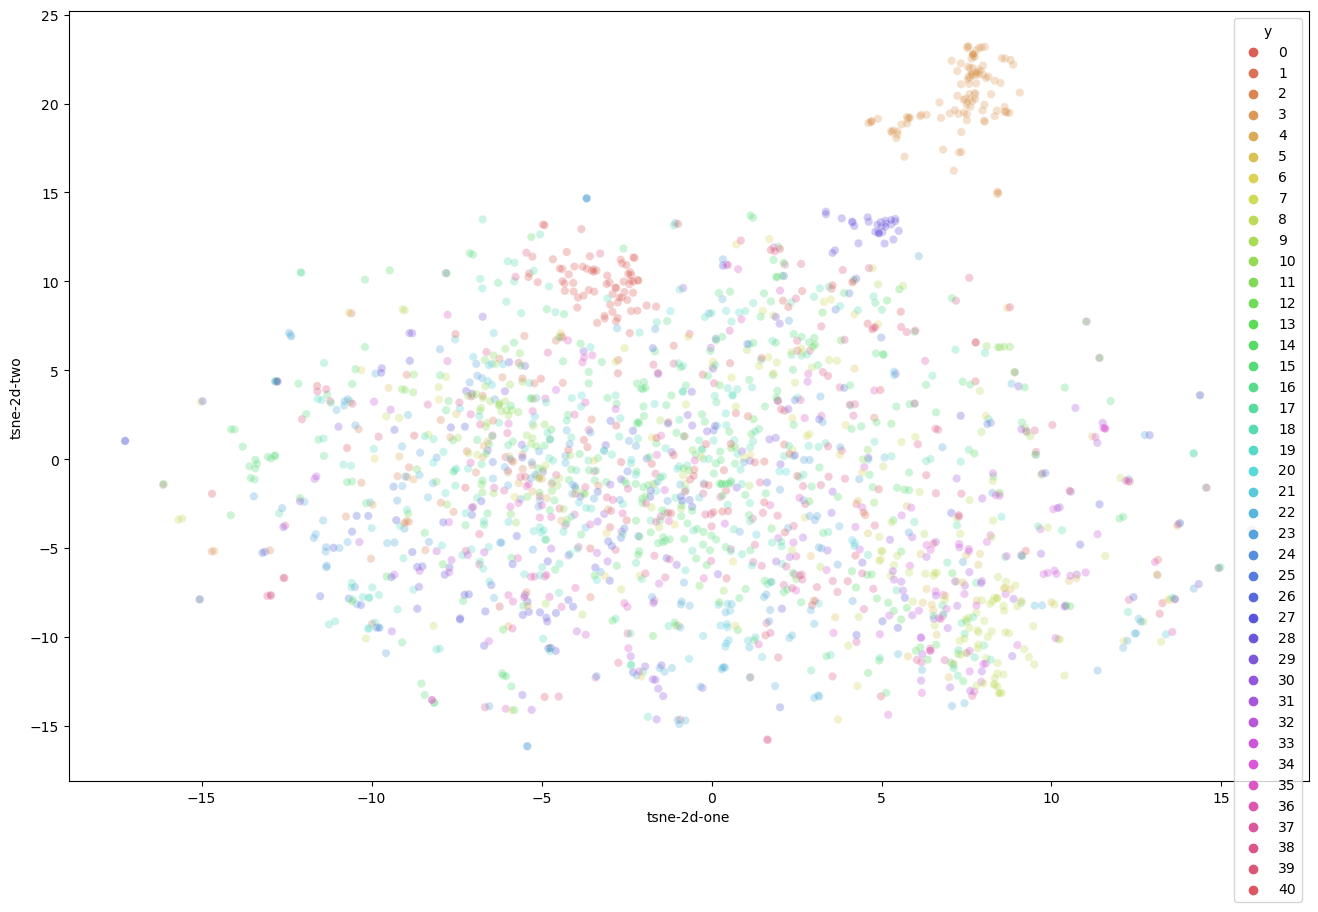

In [16]:
tsne_preproc = tsne(x)
subset_exps = pd.DataFrame(subset_data_y, columns=['y'])
subset_exps['tsne-2d-one'] = tsne_preproc[:, 0]
subset_exps['tsne-2d-two'] = tsne_preproc[:, 1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 41),
    data=subset_exps,
    legend="full",
    alpha=0.3
)

Now, we will apply graphSAGE. 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device, 'x', 'y')
kwargs = {'batch_size': 1024, 'num_workers': 6, 'persistent_workers': True}
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[25, 10], shuffle=True, **kwargs)

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)

In [4]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all
def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples, total_correct / total_examples
@torch.no_grad()
def test():
    model.eval()
    y_hat = model.inference(data.x, subgraph_loader).argmax(dim=-1)
    y = data.y.to(y_hat.device)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((y_hat[mask] == y[mask]).sum()) / int(mask.sum()))
    return accs

In [19]:
model = SAGE(dataset.num_features, 128, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
times = []
for epoch in range(1, 3):
    start = time.time()
    loss, acc = train(epoch)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch 01: 100%|███████████████████████| 153431/153431 [01:10<00:00, 2165.95it/s]


Epoch 01, Loss: 0.4748, Approx. Train: 0.8927


Evaluating: 100%|█████████████████████| 465930/465930 [01:55<00:00, 4035.27it/s]


Epoch: 01, Train: 0.9543, Val: 0.9548, Test: 0.9532


Epoch 02: 100%|███████████████████████| 153431/153431 [01:13<00:00, 2084.16it/s]


Epoch 02, Loss: 0.3294, Approx. Train: 0.9289


Evaluating: 100%|█████████████████████| 465930/465930 [01:53<00:00, 4115.39it/s]


Epoch: 02, Train: 0.9556, Val: 0.9527, Test: 0.9524
Median time per epoch: 186.6330s


In [20]:
class embed(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(model.convs[0])

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [21]:
rep = embed(model)
for batch in train_loader:
    y = batch.y[:batch.batch_size]
    x = batch.x
    y_hat = rep(batch.x, batch.edge_index.to(device))[:batch.batch_size]
    break;

In [ ]:
x_tsne_pre = np.array(x,dtype=np.double )
y_label = np.array(y)
tsne_preproc = tsne(x_tsne_pre)
subset_exps = pd.DataFrame(y, columns=['y'])
subset_exps['tsne-2d-one'] = tsne_preproc[:, 0]
subset_exps['tsne-2d-two'] = tsne_preproc[:, 1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 41),
    data=subset_exps,
    legend="full",
    alpha=0.3
)

In [15]:
x_embed.dtype

dtype('float64')

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

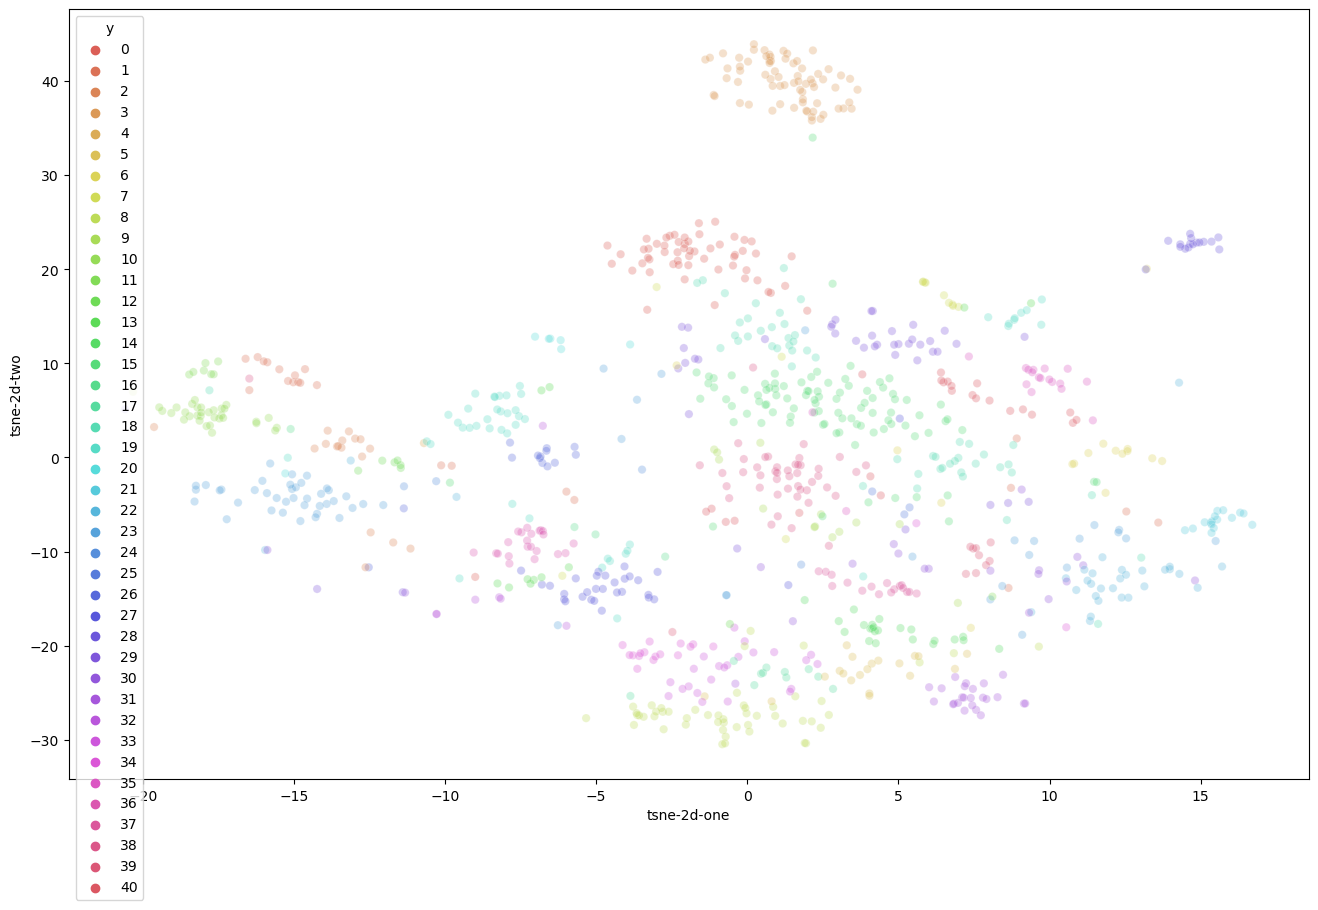

In [22]:
x_embed = y_hat.detach().numpy().astype('float64') 
tsne_embed = tsne(x_embed)
subset_exps_emb = pd.DataFrame(y, columns=['y'])
subset_exps_emb['tsne-2d-one'] = tsne_embed[:, 0]
subset_exps_emb['tsne-2d-two'] = tsne_embed[:, 1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 41),
    data=subset_exps_emb,
    legend="full",
    alpha=0.3
)

### Twitch dataset

In [25]:
twitch_dataset = Twitch('\tmp\twitch', 'EN')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_twitch = twitch_dataset[0].to(device, 'x', 'y')
kwargs = {'batch_size': 1024, 'num_workers': 6, 'persistent_workers': True}
train_loader_twitch = NeighborLoader(data_twitch, input_nodes=data.train_mask,
                              num_neighbors=[25, 10], shuffle=True, **kwargs)

subgraph_loader_twitch = NeighborLoader(copy.copy(data_twitch), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

Processing...
Done!


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

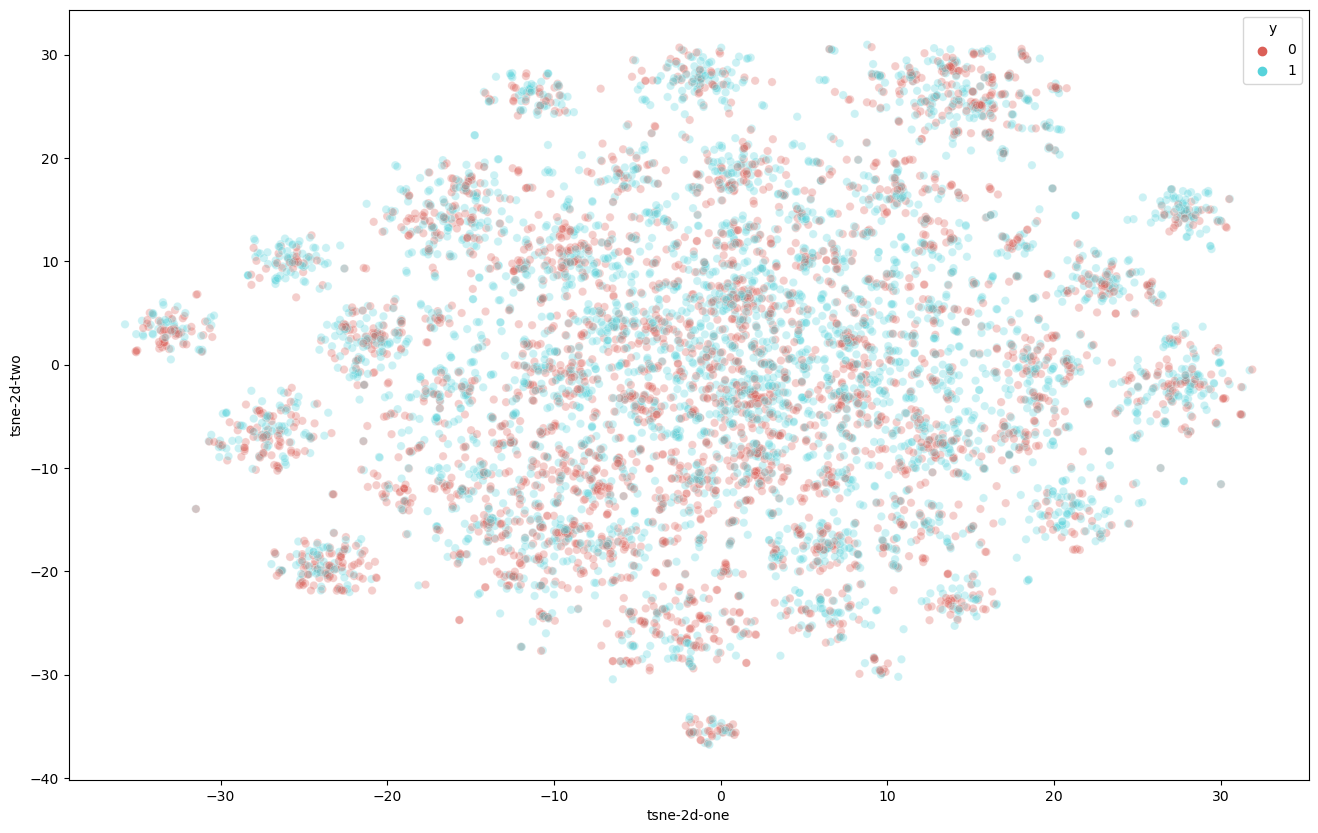

In [30]:
x = data_twitch.x.detach().numpy().astype('float64') 
tsne_preproc = tsne(x)
subset_exps = pd.DataFrame(data_twitch.y.detach().numpy(), columns=['y'])
subset_exps['tsne-2d-one'] = tsne_preproc[:, 0]
subset_exps['tsne-2d-two'] = tsne_preproc[:, 1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=subset_exps,
    legend="full",
    alpha=0.3
)

In [31]:
def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader_twitch:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples, total_correct / total_examples
@torch.no_grad()
def test():
    model.eval()
    y_hat = model.inference(data.x, subgraph_loader_twitch).argmax(dim=-1)
    y = data.y.to(y_hat.device)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((y_hat[mask] == y[mask]).sum()) / int(mask.sum()))
    return accs

In [32]:
model = SAGE(twitch_dataset.num_features, 128, twitch_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
times = []
for epoch in range(1, 3):
    start = time.time()
    loss, acc = train(epoch)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch 01:   0%|                                      | 0/153431 [00:00<?, ?it/s]ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 

RuntimeError: DataLoader worker (pid(s) 45941, 45943) exited unexpectedly